In [1]:
%cd /qbio/ari/works/hcmv/hcmv_ont/

/qbio/ari/works/hcmv/hcmv_ont


In [4]:
import pandas as pd
import numpy as np
import pysam
import re

from matplotlib import pyplot as plt
from matplotlib import colors


from copy import copy

palette = copy(plt.cm.viridis)
palette.set_over('magenta', 1.0)
palette.set_under('black', 1.0)
palette.set_bad('magenta', 1.0)

In [19]:
sample_names = 'latent react lytic'.split(' ')
sample_colors = {
    'latent': '#ffd700',
    'react' :'#fa8072',
    'lytic' : '#1e90ff'
}

from Bio import Seq
from Bio import SeqIO
refseqs = {seq.name: str(seq.seq) for seq in SeqIO.parse(open('../refs/HCMV-Toledo.fasta'), 'fasta')}

In [6]:
cigar_pat = re.compile('\\d+[A-Z]')

In [7]:
def get_switching_sites(cigar, refstart):
    tokens = cigar_pat.findall(cigar)
    refpos = refstart

    for tok in tokens:
        op = tok[-1]
        length = int(tok[:-1])
        if (op == 'N') & (length >= 40):
            
            yield refpos, refpos + length
        if op in 'MDN':
            refpos += length

In [8]:
sample_names = 'latent react lytic'.split(' ')

lnccolors = {
    'RNA2.7': [2362, 4874, '#82c91e', '-'],
    'RNA1.2': [6634, 7684, '#ffd43b', '-'],
    'RNA4.9': [93949, 98873, '#3bc9db', '+'],
    #'RNA5.0': [155744,  161422 , '#e64980', '-'],
}


lncanno = pd.DataFrame(lnccolors,
                      index='start end color strand'.split(' '))
                      #columns=['name', 'start', 'end', 'color'])
lncanno = lncanno.T
lncanno


,start,end,color,strand
RNA2.7,2362,4874,#82c91e,-
RNA1.2,6634,7684,#ffd43b,-
RNA4.9,93949,98873,#3bc9db,+


In [9]:
covlatent1 = pd.read_csv('stats/hcmv_latent_1.v.cov.txt',
                   sep='\t', names='chrom pos count'.split(' '))
covlatent2 = pd.read_csv('stats/hcmv_latent_2.v.cov.txt',
                   sep='\t', names='chrom pos count'.split(' '))
covreact1 = pd.read_csv('stats/hcmv_react_1.v.cov.txt',
                   sep='\t', names='chrom pos count'.split(' '))
covreact2 = pd.read_csv('stats/hcmv_react_2.v.cov.txt',
                   sep='\t', names='chrom pos count'.split(' '))
covlytic1 = pd.read_csv('stats/hcmv_lytic_1.v.cov.txt',
                   sep='\t', names='chrom pos count'.split(' '))

covlatent = pd.merge(covlatent1, covlatent2, left_on='pos', right_on='pos')
covlatent['count'] = covlatent['count_x']+covlatent['count_y']

covreact = pd.merge(covreact1, covreact2, left_on='pos', right_on='pos')
covreact['count'] = covreact['count_x']+covreact['count_y']

In [13]:
def plotcov(data, ax, **kwards):
    STRIDESIZE=10
    cov = data.copy()
    cov['binpos'] = np.floor(cov['pos']/STRIDESIZE).astype(int)*STRIDESIZE
    medcov_ = cov.groupby('binpos').agg({'count': 'median'})
    medcov_ = medcov_.fillna(0)
    ax.plot(medcov_.index, medcov_['count'].tolist(), **kwards)
    #ax.set_ylim(0, 170000)




    
sample_colors = {
    'latent': '#ffd700',
    'react' :'#fa8072',
    'lytic' : '#1e90ff'
}


In [11]:
def get_cov_strand(sample):
    cov1 = pd.read_csv(f'stats/hcmv_{sample}_1_+.v.cov.txt', sep='\t',
                       names='chrom pos cov'.split(' '))
    cov2 = pd.read_csv(f'stats/hcmv_{sample}_2_+.v.cov.txt', sep='\t',
                       names='chrom pos cov'.split(' '))
    covp = pd.merge(cov1, cov2, left_on='pos', right_on='pos')
    covp['count'] = covp['cov_x']+covp['cov_y']
    
    cov1 = pd.read_csv(f'stats/hcmv_{sample}_1_-.v.cov.txt', sep='\t',
                       names='chrom pos cov'.split(' '))
    cov2 = pd.read_csv(f'stats/hcmv_{sample}_2_-.v.cov.txt', sep='\t',
                       names='chrom pos cov'.split(' '))
    covm = pd.merge(cov1, cov2, left_on='pos', right_on='pos')
    covm['count'] = covm['cov_x']+covm['cov_y']
    
    return(covp, covm)
    

covlatent_p, covlatent_m = get_cov_strand('latent')
covreact_p, covreact_m = get_cov_strand('react')

In [12]:
covlytic_p = pd.read_csv('stats/hcmv_lytic_1_+.v.cov.txt', sep='\t',
                       names='chrom pos count'.split(' '))
covlytic_m = pd.read_csv('stats/hcmv_lytic_1_-.v.cov.txt', sep='\t',
                       names='chrom pos count'.split(' '))

In [14]:
def extract_junction(inpfile):
    output_list=[]
    for aln in pysam.AlignmentFile(inpfile):
        if aln.cigarstring is None or 'N' not in aln.cigarstring:
            continue

        strand = '-' if aln.is_reverse else '+'
        chrom = aln.reference_name

        for i, (sstart, send) in enumerate(get_switching_sites(aln.cigarstring, aln.reference_start)):
            output_list.append([f'{aln.query_name}_{i}', chrom, strand, sstart, send])
    return(output_list)
            


latent_junction = []
latent_junction.extend(extract_junction('alignments/hcmv_latent_1.sorted.v.bam'))
latent_junction.extend(extract_junction('alignments/hcmv_latent_2.sorted.v.bam'))

react_junction = []
react_junction.extend(extract_junction('alignments/hcmv_react_1.sorted.v.bam'))
react_junction.extend(extract_junction('alignments/hcmv_react_2.sorted.v.bam'))

lytic_junction = extract_junction('alignments/hcmv_lytic_1.sorted.v.bam')

In [15]:

latent_junction = pd.DataFrame(np.array(latent_junction),
                               columns='read_id chrom strand sstart send'.split(' '),
                               )
react_junction = pd.DataFrame(np.array(react_junction),
                              columns='read_id chrom strand sstart send'.split(' '))
lytic_junction = pd.DataFrame(np.array(lytic_junction),
                              columns='read_id chrom strand sstart send'.split(' '))

In [20]:
def get_delcov(junction):
    plusjunc = np.zeros(len(refseqs['GU937742.2']))
    minusjunc = np.zeros(len(refseqs['GU937742.2']))
    
    junction_p = junction[junction['strand']=='+']
    junction_m = junction[junction['strand']=='-']    
    
    for _, line in junction_p.iterrows():
        
        
        plusjunc[range(int(line['sstart']),
                       int(line['send']))] +=1
        
    for _, line in junction_m.iterrows():
        
        
        minusjunc[range(int(line['sstart']),
                       int(line['send']))] +=1
        
    delcov = pd.DataFrame([np.arange(0, len(refseqs['GU937742.2'])), plusjunc, minusjunc],
                         index=['pos', '+', '-']).T
    delcov = delcov.astype(int)
    return(delcov)
    #print(plusjunc)
lytic_del = get_delcov(lytic_junction)

In [21]:
latent_del = get_delcov(latent_junction)
react_del = get_delcov(react_junction)

        count_latent  del_latent  count_react  del_react  count_lytic  \
binpos                                                                  
0                0.0         0.0          0.0        0.0           47   
10               0.0         0.0          0.0        0.0          128   
20               0.0         0.0          0.0        0.0          228   
30               0.0         0.0          0.0        0.0          285   
40               0.0         0.0          0.0        0.0          382   
...              ...         ...          ...        ...          ...   
235310           0.0         0.0          0.0        0.0           18   
235320           0.0         0.0          0.0        0.0           18   
235330           0.0         0.0          0.0        0.0           10   
235340           0.0         0.0          0.0        0.0           14   
235350           0.0         0.0          0.0        0.0           14   

        del_lytic  
binpos             
0         

(2362.0, 7684.0)

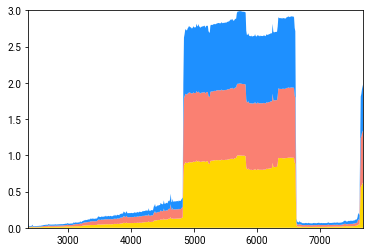

In [22]:
def get_longdel(covdata, deldata, strand, ax, **kwards):
    STRIDESIZE=10
    cov = covdata.copy()
    cov['binpos'] = np.floor(cov['pos']/STRIDESIZE).astype(int)*STRIDESIZE
    
    medcov_ = cov.groupby('binpos').sum()['count']
    medcov_ = medcov_.fillna(0)
    
    
    #delcov = delcov[['pos', strand]]
    delcov = deldata.copy()
    delcov['binpos'] = np.floor(delcov['pos']/STRIDESIZE).astype(int)*STRIDESIZE
    #print(delcov)
    meddelcov_ = delcov.groupby('binpos').sum()[strand]
    
    meddelcov_ = meddelcov_.fillna(0)
    
    
    
    covs = pd.merge(medcov_, meddelcov_, left_on='binpos', right_on='binpos')

    #print(delcov['-'].max())
    return(covs)

fig, ax = plt.subplots(1,1)
covs_lytic = get_longdel(covlytic_m, lytic_del, '-', ax, color=sample_colors['lytic'])
covs_latent = get_longdel(covlatent_m, latent_del, '-', ax, color=sample_colors['latent'])
covs_react = get_longdel(covreact_m, react_del, '-', ax, color=sample_colors['react'])

minus_covs = pd.concat([covs_latent, covs_react, covs_lytic], axis=1).fillna(0)

minus_covs.columns = 'count_latent del_latent count_react del_react count_lytic del_lytic'.split(' ')
print(minus_covs)


ax.stackplot(minus_covs.index, (minus_covs['del_latent']+1)/(minus_covs['count_latent']+1),
            (minus_covs['del_react']+1)/(minus_covs['count_react']+1),
            (minus_covs['del_lytic']+1)/(minus_covs['count_lytic']+1),
            colors=sample_colors.values(),
            labels=sample_names)
ax.set_ylim(0,3)

ax.set_xlim(2362, 7684)

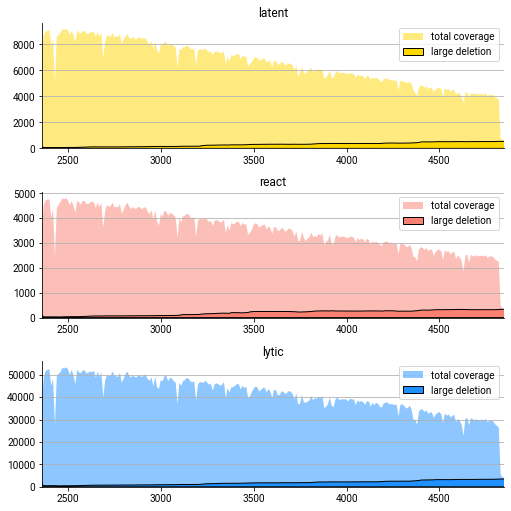

In [23]:
fig, axes = plt.subplots(3,1, figsize = (4.8*1.5, 4.8*1.5), facecolor='white')
for i, sample in enumerate(sample_names):
    ax=axes[i]
    ax.stackplot(minus_covs.index, minus_covs[f'count_{sample}']/10, 
            colors=sample_colors[sample],
           labels=['total coverage'], alpha=.5)
    ax.stackplot(minus_covs.index, minus_covs[f'del_{sample}']/10, 
            colors=sample_colors[sample],
           labels=['large deletion'], edgecolor='black')
    
    for sp in 'top right'.split():
        ax.spines[sp].set_visible(False)
    ax.grid(axis='y')
    ax.legend()
    ax.set_title(sample)
    
    ax.set_xlim(2362, 4848)
    

    
    
plt.tight_layout()

(0.0, 35000.0)

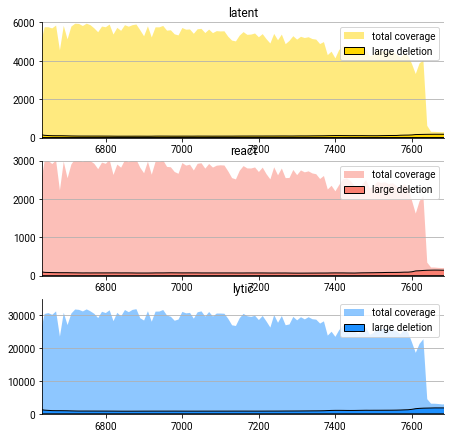

In [24]:
fig, axes = plt.subplots(3,1, figsize = (4.8*1.5, 4.8*1.5), facecolor='white')
for i, sample in enumerate(sample_names):
    ax=axes[i]
    ax=axes[i]
    ax.stackplot(minus_covs.index, minus_covs[f'count_{sample}']/10, 
            colors=sample_colors[sample],
           labels=['total coverage'], alpha=.5)
    ax.stackplot(minus_covs.index, minus_covs[f'del_{sample}']/10, 
            colors=sample_colors[sample],
           labels=['large deletion'], edgecolor='black')
    
    for sp in 'top right'.split():
        ax.spines[sp].set_visible(False)
    ax.grid(axis='y')
    ax.legend()
    ax.set_title(sample)
    
    
    ax.set_xlim(6634  ,7684)

axes[0].set_ylim(0,6000)
axes[1].set_ylim(0,3000)
axes[2].set_ylim(0,35000)
    
    


(0.0, 3000.0)

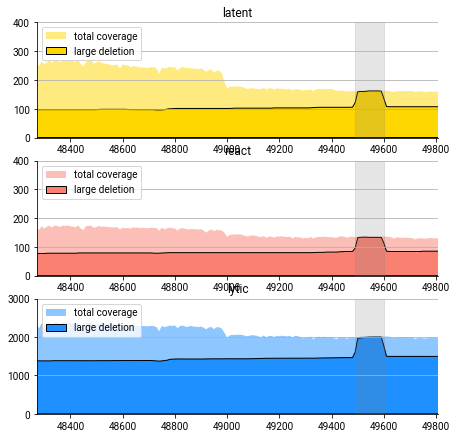

In [25]:
fig, axes = plt.subplots(3,1, figsize = (4.8*1.5, 4.8*1.5), facecolor='white')
for i, sample in enumerate(sample_names):
    ax=axes[i]
    ax=axes[i]
    ax.stackplot(minus_covs.index, minus_covs[f'count_{sample}']/10, 
            colors=sample_colors[sample],
           labels=['total coverage'], alpha=.5)
    ax.stackplot(minus_covs.index, minus_covs[f'del_{sample}']/10, 
            colors=sample_colors[sample],
           labels=['large deletion'], edgecolor='black')
    
    for sp in 'top right'.split():
        ax.spines[sp].set_visible(False)
    ax.grid(axis='y')
    ax.legend()
    ax.set_title(sample)
    
    
    ax.set_xlim(48271  ,49809 )
    ax.set_ylim(0,400)
    ax.set_rasterized(True)
    ax.axvspan(49490, 49600, color='grey', alpha=.2)

axes[2].set_ylim(0,3000)
    

(0.0, 1500.0)

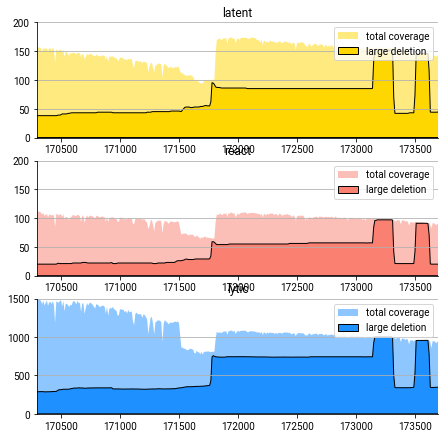

In [26]:
fig, axes = plt.subplots(3,1, figsize = (4.8*1.5, 4.8*1.5), facecolor='white')
for i, sample in enumerate(sample_names):
    ax=axes[i]
    ax=axes[i]
    ax.stackplot(minus_covs.index, minus_covs[f'count_{sample}']/10, 
            colors=sample_colors[sample],
           labels=['total coverage'], alpha=.5)
    ax.stackplot(minus_covs.index, minus_covs[f'del_{sample}']/10, 
            colors=sample_colors[sample],
           labels=['large deletion'], edgecolor='black')
    
    for sp in 'top right'.split():
        ax.spines[sp].set_visible(False)
    ax.grid(axis='y')
    ax.legend()
    ax.set_title(sample)
    
    
    ax.set_xlim(170294, 173699)
    
    #ax.axvspan(171780, 173320, color='black', alpha=.2, zorder=0)
    #ax.axvspan(173500, 173620, color='black', alpha=.4, zorder=0)
    #ax.axvspan(173150, 173320, color='black', alpha=.2, zorder=0)
    
    

axes[0].set_ylim(0,200)
axes[1].set_ylim(0,200)
axes[2].set_ylim(0,1500)

In [27]:
covs_lytic = get_longdel(covlytic_p, lytic_del, '+', ax, color=sample_colors['lytic'])
covs_latent = get_longdel(covlatent_p, latent_del, '+', ax, color=sample_colors['latent'])
covs_react = get_longdel(covreact_p, react_del, '+', ax, color=sample_colors['react'])

plus_covs = pd.concat([covs_latent, covs_react, covs_lytic], axis=1).fillna(0)

plus_covs.columns = 'count_latent del_latent count_react del_react count_lytic del_lytic'.split(' ')


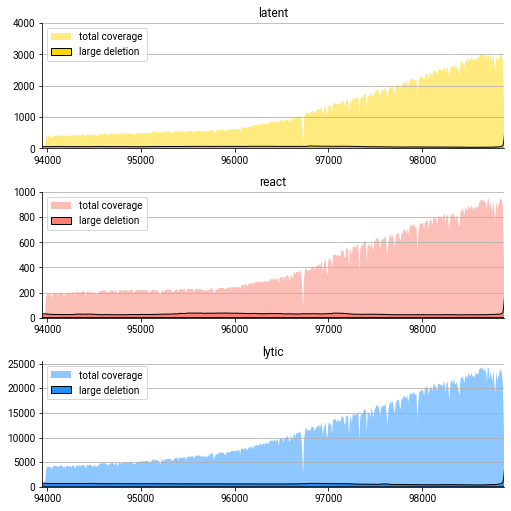

In [28]:
fig, axes = plt.subplots(3,1, figsize = (4.8*1.5, 4.8*1.5), facecolor='white')
for i, sample in enumerate(sample_names):
    ax=axes[i]
    ax.stackplot(plus_covs.index, plus_covs[f'count_{sample}']/10, 
            colors=sample_colors[sample],
           labels=['total coverage'], alpha=.5)
    ax.stackplot(plus_covs.index, plus_covs[f'del_{sample}']/10, 
            colors=sample_colors[sample],
           labels=['large deletion'], edgecolor='black')
    
    for sp in 'top right'.split():
        ax.spines[sp].set_visible(False)
    ax.grid(axis='y')
    ax.legend(loc='upper left')
    ax.set_title(sample)
    
    ax.set_xlim(93949,98873	)
axes[0].set_ylim(0,4000)
axes[1].set_ylim(0,1000)
#axes[2].set_ylim(0,5000)

    
    
plt.tight_layout()